In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 818.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninsta

In [ ]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
register_coco_instances("train", {}, "/content/drive/MyDrive/CarDD_COCO/annotations/instances_train2017.json", "/content/drive/MyDrive/CarDD_COCO/train2017")
register_coco_instances("valid", {}, "/content/drive/MyDrive/CarDD_COCO/annotations/instances_val2017.json", "/content/drive/MyDrive/CarDD_COCO/val2017")
register_coco_instances("test", {}, "/content/drive/MyDrive/CarDD_COCO/annotations/instances_test2017.json", "/content/drive/MyDrive/CarDD_COCO/test2017")

In [ ]:
dataset_train = DatasetCatalog.get("train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

[12/11 18:36:40 d2.data.datasets.coco]: Loading /content/drive/MyDrive/CarDD_COCO/annotations/instances_train2017.json takes 2.52 seconds.
[12/11 18:36:40 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /content/drive/MyDrive/CarDD_COCO/annotations/instances_train2017.json


In [ ]:
import detectron2.utils.comm as comm
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, LVISEvaluator, PascalVOCDetectionEvaluator, SemSegEvaluator, CityscapesInstanceEvaluator, CityscapesSemSegEvaluator, COCOPanopticEvaluator
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.data import MetadataCatalog
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.data import MetadataCatalog
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils import comm
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_train_loader, build_detection_test_loader


In [ ]:
import copy
import torch
import numpy as np

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
        T.RandomRotation(angle=[90, 180, 270]),  # Simple rotation
        T.RandomContrast(0.8, 1.2),             # Random contrast
        T.RandomBrightness(0.8, 1.2),           # Random brightness
    ]

    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


[12/11 18:37:37 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /content/drive/MyDrive/CarDD_COCO/annotations/instances_train2017.json


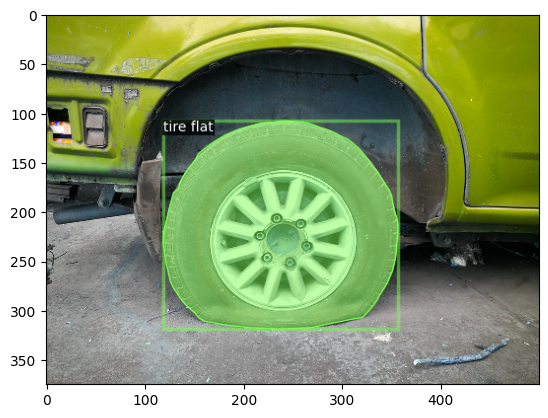

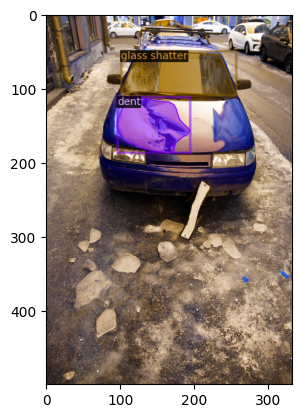

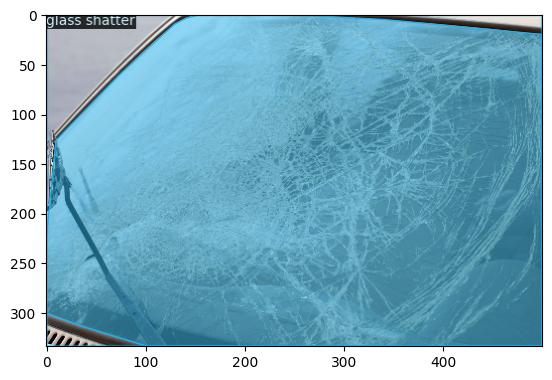

In [ ]:
# Check your custom data mapper by visualizing a few samples
dataset_dicts = DatasetCatalog.get("train")  # Assuming "train" is the name of your registered dataset
for d in random.sample(dataset_dicts, 3):  # Change 3 to the number of samples you want to visualize
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train"), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()


In [ ]:
pwd

'/content'

In [ ]:
# Set custom data augmentation function
cfg = get_cfg()
cfg.INPUT.MAPPER = "custom_mapper"

# Other configurations
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg.TEST.EVAL_PERIOD = 0
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

PATIENCE = 1000
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    model_last_iter_path = os.path.join(cfg.OUTPUT_DIR, "model_last_iter.pth")
                    checkpointer.save(model_last_iter_path)
                    break

do_test(cfg, model)

[12/11 17:06:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:02, 70.7MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/11 17:06:31 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /content/drive/MyDrive/CarDD_COCO/annotations/instances_train2017.json
[12/11 17:06:31 d2.data.build]: Removed 0 images with no usable annotations. 2816 images left.
[12/11 17:06:31 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
|     dent      | 1806         |   scratch   | 2560         |   crack    | 651          |
| glass shatter | 475          | lamp broken | 494          | tire flat  | 225          |
|               |              |             |              |            |              |
|     total     | 6211         |             |              |            |              |
[12/11 17:06:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


[12/11 17:06:46 d2.utils.events]:  iter: 19  total_loss: 2.679  loss_cls: 1.782  loss_box_reg: 0.09638  loss_mask: 0.6933  loss_rpn_cls: 0.08598  loss_rpn_loc: 0.03291     lr: 4.9953e-06  max_mem: 2671M
[12/11 17:07:00 d2.utils.events]:  eta: 1:53:36  iter: 39  total_loss: 2.553  loss_cls: 1.604  loss_box_reg: 0.1232  loss_mask: 0.6933  loss_rpn_cls: 0.07008  loss_rpn_loc: 0.02778     lr: 9.9902e-06  max_mem: 2672M
[12/11 17:07:10 d2.utils.events]:  eta: 1:23:12  iter: 59  total_loss: 2.252  loss_cls: 1.364  loss_box_reg: 0.1129  loss_mask: 0.6918  loss_rpn_cls: 0.08147  loss_rpn_loc: 0.02961     lr: 1.4985e-05  max_mem: 2672M
[12/11 17:07:20 d2.utils.events]:  eta: 1:20:57  iter: 79  total_loss: 1.934  loss_cls: 0.9252  loss_box_reg: 0.1456  loss_mask: 0.6905  loss_rpn_cls: 0.124  loss_rpn_loc: 0.02373     lr: 1.998e-05  max_mem: 2672M
[12/11 17:07:30 d2.utils.events]:  eta: 1:23:42  iter: 99  total_loss: 1.53  loss_cls: 0.5862  loss_box_reg: 0.1259  loss_mask: 0.6873  loss_rpn_cls: 0

AssertionError: ignored

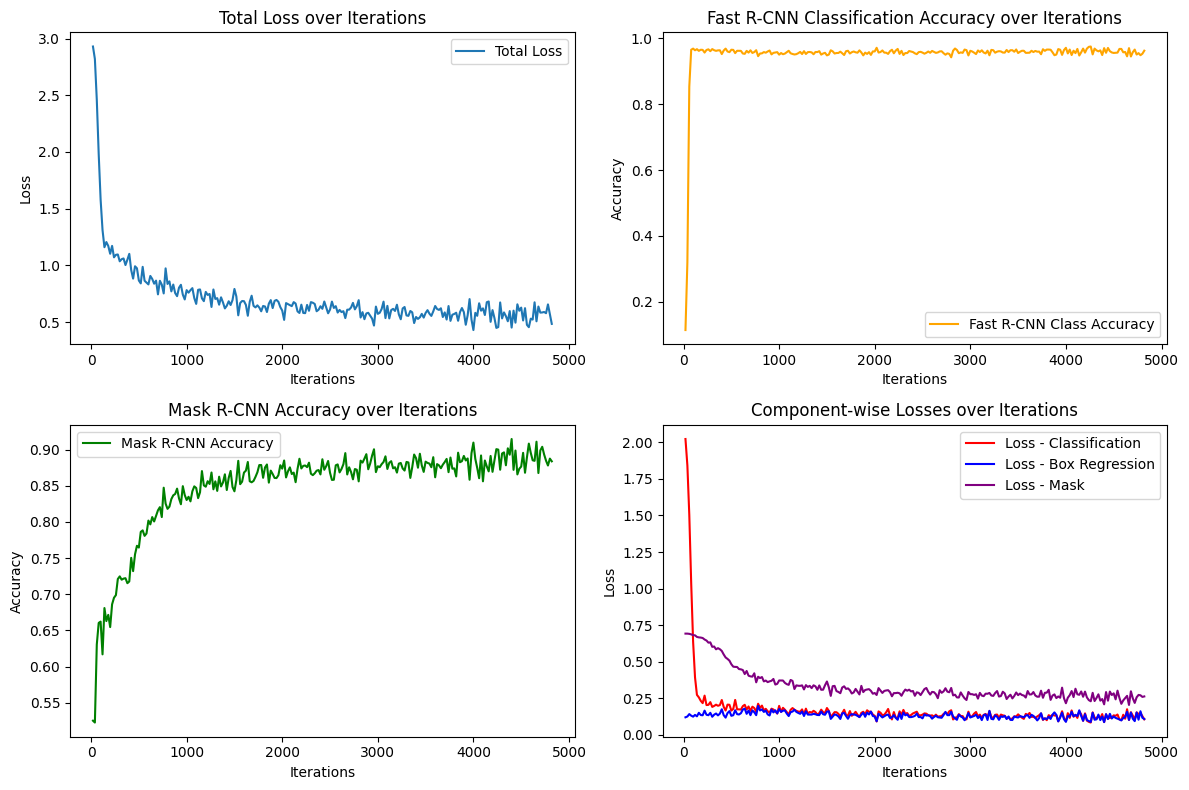

In [ ]:
import json
import matplotlib.pyplot as plt
from collections import defaultdict

# Path to your metrics.json file
metrics_file = '/content/output/metrics.json'  # Update this path

# Read the file and parse the JSON
with open(metrics_file, 'r') as file:
    lines = file.readlines()

metrics = [json.loads(line) for line in lines]

# Data structure to store aggregated metrics
aggregated_metrics = defaultdict(lambda: defaultdict(list))

# Aggregate metrics
for m in metrics:
    if all(k in m for k in ['iteration', 'total_loss', 'fast_rcnn/cls_accuracy', 'mask_rcnn/accuracy', 'loss_cls', 'loss_box_reg', 'loss_mask']):
        iteration = m['iteration']
        aggregated_metrics[iteration]['total_loss'].append(m['total_loss'])
        aggregated_metrics[iteration]['cls_accuracy'].append(m['fast_rcnn/cls_accuracy'])
        aggregated_metrics[iteration]['mask_accuracy'].append(m['mask_rcnn/accuracy'])
        aggregated_metrics[iteration]['loss_cls'].append(m['loss_cls'])
        aggregated_metrics[iteration]['loss_box_reg'].append(m['loss_box_reg'])
        aggregated_metrics[iteration]['loss_mask'].append(m['loss_mask'])

# Compute averages for each iteration
averaged_metrics = defaultdict(dict)
for iteration, metrics in aggregated_metrics.items():
    for metric, values in metrics.items():
        averaged_metrics[iteration][metric] = sum(values) / len(values)

# Separate metrics for plotting
iterations = sorted(averaged_metrics.keys())
total_losses = [averaged_metrics[i]['total_loss'] for i in iterations]
cls_accuracies = [averaged_metrics[i]['cls_accuracy'] for i in iterations]
mask_accuracies = [averaged_metrics[i]['mask_accuracy'] for i in iterations]
loss_cls = [averaged_metrics[i]['loss_cls'] for i in iterations]
loss_box_reg = [averaged_metrics[i]['loss_box_reg'] for i in iterations]
loss_mask = [averaged_metrics[i]['loss_mask'] for i in iterations]

# Plotting
plt.figure(figsize=(12, 8))

# Total loss
plt.subplot(2, 2, 1)
plt.plot(iterations, total_losses, label='Total Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Total Loss over Iterations')
plt.legend()

# Classification Accuracy
plt.subplot(2, 2, 2)
plt.plot(iterations, cls_accuracies, label='Fast R-CNN Class Accuracy', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Fast R-CNN Classification Accuracy over Iterations')
plt.legend()

# Mask Accuracy
plt.subplot(2, 2, 3)
plt.plot(iterations, mask_accuracies, label='Mask R-CNN Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Mask R-CNN Accuracy over Iterations')
plt.legend()

# Losses for Classification, Box Regression, and Mask
plt.subplot(2, 2, 4)
plt.plot(iterations, loss_cls, label='Loss - Classification', color='red')
plt.plot(iterations, loss_box_reg, label='Loss - Box Regression', color='blue')
plt.plot(iterations, loss_mask, label='Loss - Mask', color='purple')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Component-wise Losses over Iterations')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0003999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("test")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = Image.fromarray(out.get_image()[:, :, ::-1])
    im

[12/10 18:07:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_0003999.pth ...
[12/10 18:07:43 d2.data.datasets.coco]: Loaded 374 images in COCO format from /content/drive/MyDrive/CarDD_COCO/annotations/instances_test2017.json


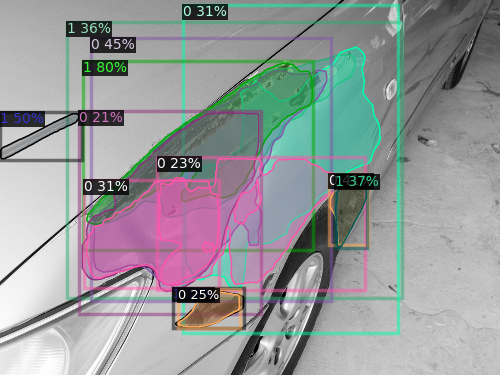

In [ ]:
im

[12/11 20:58:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_0003999.pth ...
[12/11 20:58:07 d2.data.datasets.coco]: Loaded 374 images in COCO format from /content/drive/MyDrive/CarDD_COCO/annotations/instances_test2017.json


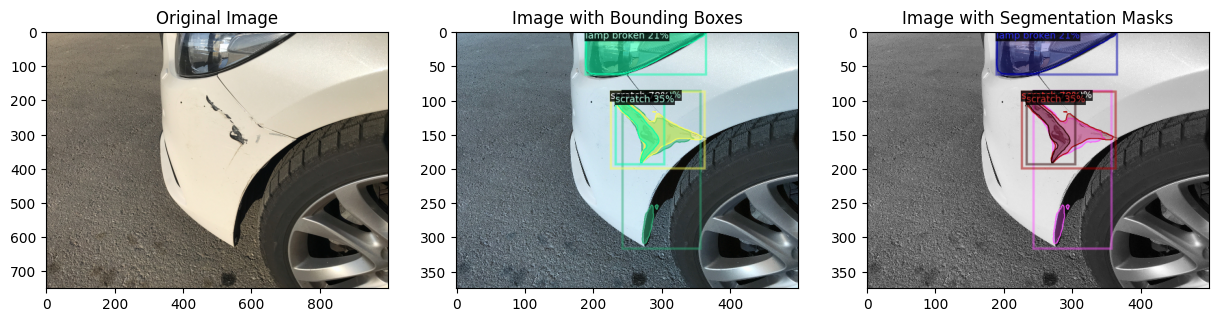

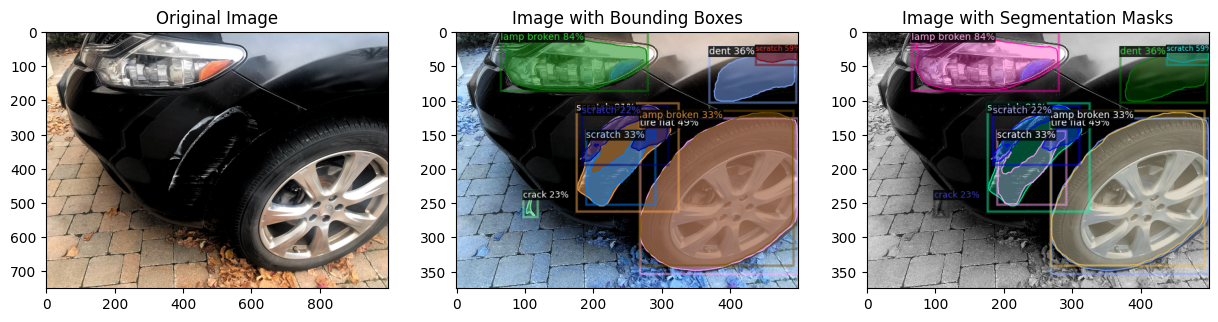

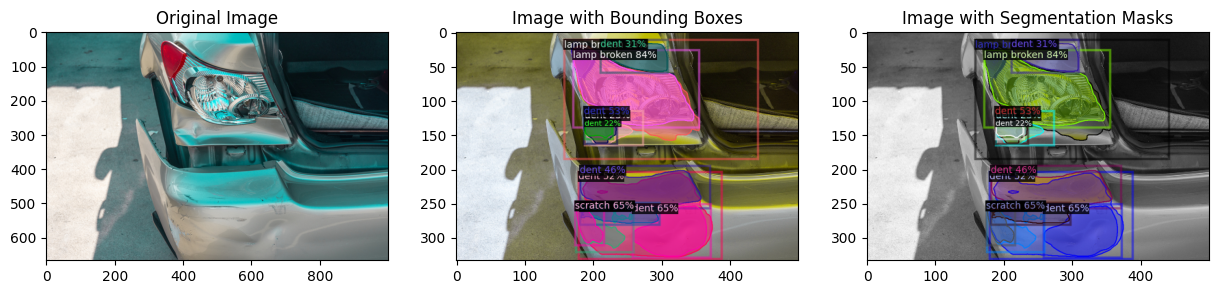

In [ ]:
import matplotlib.pyplot as plt

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0003999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("test")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    # Draw bounding boxes
    v_bbox = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=0.5)
    out_bbox = v_bbox.draw_instance_predictions(outputs["instances"].to("cpu"))
    im_bbox = Image.fromarray(out_bbox.get_image()[:, :, ::-1])

    # Draw segmentation masks
    v_mask = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=0.5, instance_mode=ColorMode.IMAGE_BW)
    out_mask = v_mask.draw_instance_predictions(outputs["instances"].to("cpu"))
    im_mask = Image.fromarray(out_mask.get_image()[:, :, ::-1])

    # Display the original image along with bounding boxes and masks
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    ax[0].imshow(im[:, :, ::-1])
    ax[0].set_title('Original Image')

    # Image with Bounding Boxes
    ax[1].imshow(im_bbox)
    ax[1].set_title('Image with Bounding Boxes')

    # Image with Segmentation Masks
    ax[2].imshow(im_mask)
    ax[2].set_title('Image with Segmentation Masks')

    plt.show()


In [ ]:
# Initialize the configuration
cfg = get_cfg()

# Load the base configuration from model zoo
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Set the path to the trained model weights
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/output1/model_final.pth"

# Set the number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Update this based on your dataset

# Set the testing threshold for this model (adjust as needed)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

# Specify the test dataset
cfg.DATASETS.TEST = ("test",)

In [ ]:
# Create a COCOEvaluator instance for your test dataset
evaluator = COCOEvaluator("test", cfg, False, output_dir="/content/drive/MyDrive/output/evaluation")

# Build the test data loader
test_loader = build_detection_test_loader(cfg, "test")

# Run the model on the test data and get the evaluation metrics
inference_on_dataset(predictor.model, test_loader, evaluator)

WARNING [12/10 18:13:17 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/10 18:13:17 d2.data.datasets.coco]: Loaded 374 images in COCO format from /content/drive/MyDrive/CarDD_COCO/annotations/instances_test2017.json
[12/10 18:13:17 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
|     dent      | 236          |   scratch   | 307          |   crack    | 70           |
| glass shatter | 71           | lamp broken | 69           | tire flat  | 32           |
|               |              |             |              |            |              |
|     total     | 785          |             |              |            |              |
[12/10 18:13:17 d2.data.dataset_mapper]: [DatasetMapper] Aug

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


[12/10 18:13:22 d2.evaluation.evaluator]: Inference done 11/374. Dataloading: 0.0030 s/iter. Inference: 0.1541 s/iter. Eval: 0.0177 s/iter. Total: 0.1748 s/iter. ETA=0:01:03
[12/10 18:13:27 d2.evaluation.evaluator]: Inference done 32/374. Dataloading: 0.0738 s/iter. Inference: 0.1504 s/iter. Eval: 0.0101 s/iter. Total: 0.2345 s/iter. ETA=0:01:20
[12/10 18:13:32 d2.evaluation.evaluator]: Inference done 50/374. Dataloading: 0.0831 s/iter. Inference: 0.1563 s/iter. Eval: 0.0122 s/iter. Total: 0.2518 s/iter. ETA=0:01:21
[12/10 18:13:37 d2.evaluation.evaluator]: Inference done 72/374. Dataloading: 0.0624 s/iter. Inference: 0.1691 s/iter. Eval: 0.0149 s/iter. Total: 0.2468 s/iter. ETA=0:01:14
[12/10 18:13:43 d2.evaluation.evaluator]: Inference done 81/374. Dataloading: 0.1140 s/iter. Inference: 0.1670 s/iter. Eval: 0.0141 s/iter. Total: 0.2954 s/iter. ETA=0:01:26
[12/10 18:13:49 d2.evaluation.evaluator]: Inference done 104/374. Dataloading: 0.0989 s/iter. Inference: 0.1685 s/iter. Eval: 0.01

OrderedDict([('bbox',
              {'AP': 36.12779915560261,
               'AP50': 54.62789152961985,
               'AP75': 38.5006298718559,
               'APs': 16.75907590759076,
               'APm': 11.096652987383012,
               'APl': 36.17344159095028,
               'AP-dent': 21.35732035205912,
               'AP-scratch': 22.72803190686536,
               'AP-crack': 6.956117607881153,
               'AP-glass shatter': 71.54214403351695,
               'AP-lamp broken': 34.81484066885806,
               'AP-tire flat': 59.368340364435}),
             ('segm',
              {'AP': 37.550031807270834,
               'AP50': 53.20151823149647,
               'AP75': 38.82516172975601,
               'APs': 4.068756875687568,
               'APm': 6.985473729342112,
               'APl': 38.515400429470624,
               'AP-dent': 21.915392974008327,
               'AP-scratch': 20.723660477354287,
               'AP-crack': 3.2867958799829613,
               'AP-glas

[12/11 21:07:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_0003999.pth ...


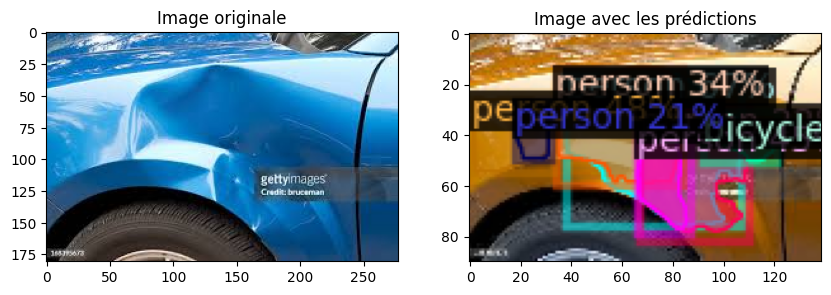